In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from deepjets import learning, models, utils
import seaborn

Using Theano backend.


//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [ ]:
model = models.get_maxout(25**2)

In [ ]:
n_images = -1
n_folds = 1
test_frac = 0.1
val_frac = 0.1
sig_file = 'images/w_images.h5'
bkd_file = 'images/qcd_images.h5'
dataset_name = 'datasets/test'
model_name = 'models/test'

In [ ]:
h5_files = utils.prepare_datasets(
    sig_file, bkd_file, dataset_name, n_sig=n_images, n_bkd=n_images, test_frac=test_frac,
    val_frac=val_frac, n_folds=n_folds, auxvars=['weights'], shuffle=True, shuffle_seed=1)

In [ ]:
learning.train_model(model, h5_files['train'], model_name)

//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


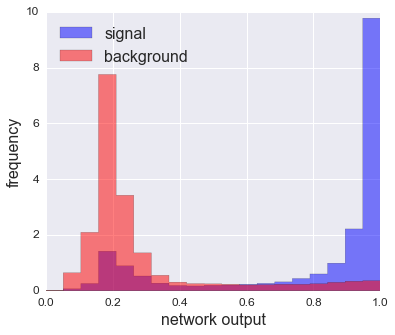

In [3]:
utils.plot_sig_bkd_dists(models.load_model('models/maxout_w_default'),
                         'datasets/w_big_test.h5')

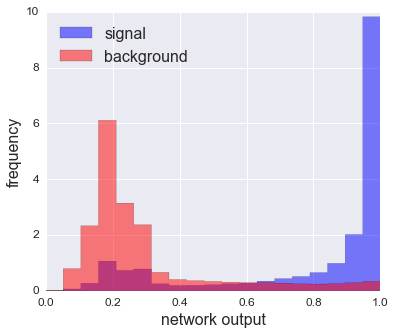

In [4]:
utils.plot_sig_bkd_dists(models.load_model('models/maxout_w_default_2'),
                         'datasets/w_big_test.h5')

In [ ]:
roc = learning.test_model(models.load_model('models/maxout_w_default'),
                          'datasets/w_big_test.h5', show_ROC_curve=False)
roc_2 = learning.test_model(models.load_model('models/maxout_w_default_2'),
                          'datasets/w_big_test.h5', show_ROC_curve=False)

Testing on 200000 samples.
Dataset from datasets/w_big_test.h5.


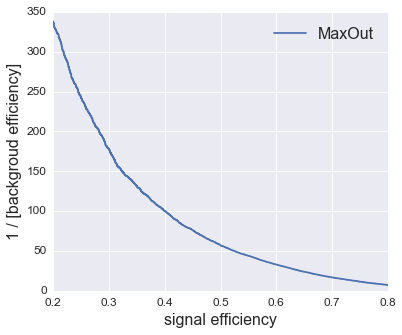

In [13]:
utils.plot_roc_curves([roc['ROC_curve'], roc_2['ROC_curve']], ['MaxOut', 'MaxOut 2'])